In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numpy import log2
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
def cal_entropy(pos,neg):
  s = pos + neg
  if(pos*neg == 0):
    return 0
  neg_ent = -(pos/s)*(log2(pos/s))
  pos_ent = - (neg/s)*(log2(neg/s)) 
  return    pos_ent + neg_ent

In [14]:
def find_ig_column(column, label):
  classes_of_column = np.unique(column)
  count_all = len(column)
  ent_all = cal_entropy(sum(label==0),sum(label==1))
  ent_subgroups = 0
  for j in range(len(classes_of_column)):
    bool_list = (column==classes_of_column[j])
    label_subgroup = label[bool_list]
    ent_subgroups += sum(bool_list)/count_all* cal_entropy(sum(label_subgroup==0), sum(label_subgroup==1))
  return ent_all - ent_subgroups


In [4]:
class node:
  def __init__(self, split_feature = None, split_value = None, return_val = None, depth = 1, sub_nodes = [],  max_depth = 3, is_leaf = False):
    self.max_depth = max_depth
    self.split_feature = split_feature
    self.split_value = split_value
    self.return_val = return_val
    self.depth_ = depth 
    self.sub_nodes = sub_nodes
    self.is_leaf = is_leaf

  def find_best_feature(self, in_data, target):
    igs = []
    for feature in in_data.columns:
      igs.append(find_ig_column(in_data[feature],target))
    igs = np.array(igs)
    return igs.argmax()
    

  def fit(self, data, label):
    if np.all(label == 1):
      self.is_leaf = True
      self.return_val =1

    elif np.all(label == 0):
      self.is_leaf = True
      self.return_val = 0

    elif len(data.columns) == 0:
      self.is_leaf = True
      self.return_val = np.argmax(np.bincount(label))

    else:
      best_feature = self.find_best_feature(data, label)
      self.split_feature = data.columns[best_feature]
      if(self.depth_ < self.max_depth):
        best_feature_classes = np.unique(data.iloc[:,best_feature])
        self.sub_nodes = [0] *len(best_feature_classes)
        for i in range(len(best_feature_classes)):
          bool_list = data.iloc[:,best_feature] == best_feature_classes[i]
          self.sub_nodes[i] = node(depth = self.depth_ + 1, split_value = best_feature_classes[i], max_depth= self.max_depth)
          self.sub_nodes[i].fit(data = data.drop(data.columns[best_feature], axis=1)[bool_list], label = label[bool_list])
      else:
        self.return_val = np.argmax(np.bincount(label))
        self.is_leaf = True

  
  def predict_sample(self,sample):
    curr_node = self
    while(curr_node.is_leaf == False):
      value = sample[curr_node.split_feature]
      for i in range(len(curr_node.sub_nodes)):
        if(curr_node.sub_nodes[i].split_value == value):
          curr_node = curr_node.sub_nodes[i]
          break
    return curr_node.return_val


  def predict(self, test_set):
    out = np.zeros(len(test_set))
    for i in range(len(test_set)):
      out[i] = self.predict_sample(test_set.iloc[i,:])
    return out

In [5]:
data_set = pd.read_csv('/content/drive/MyDrive/prison_dataset.csv')

x = data_set.iloc[:,:10]
y = data_set.iloc[:,10]
x.drop(x.columns[1], axis=1, inplace= True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
data_set.head()


,Fiscal Year Released,Recidivism Reporting Year,Race - Ethnicity,Age At Release,Convicting Offense Classification,Convicting Offense Type,Convicting Offense Subtype,Main Supervising District,Release Type,Part of Target Population,Recidivism - Return to Prison numeric
0,2010,2013,White,<45,D Felony,Violent,Other,3JD,Parole,Yes,1
1,2010,2013,White,>45,D Felony,Other,Other,3JD,Parole,Yes,1
2,2010,2013,White,<45,D Felony,Other,Other,5JD,Parole,Yes,1
3,2010,2013,White,>45,Other Felony,Drug,Trafficking,3JD,Parole,Yes,1
4,2010,2013,Black,<45,D Felony,Drug,Trafficking,3JD,Parole,Yes,1


accuray = 0.5552674230145868


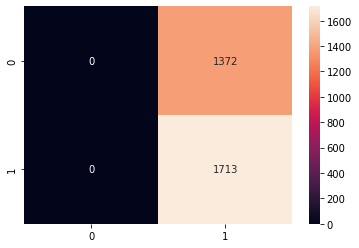

In [7]:
tree = node(max_depth = 1)
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, fmt='g')
print('accuray = {}'.format(accuracy_score(y_test,y_pred)))

accuray = 0.706645056726094


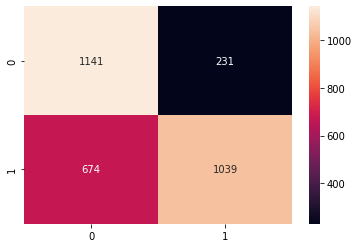

In [8]:
tree = node(max_depth = 3)
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, fmt='g')
print('accuray = {}'.format(accuracy_score(y_test,y_pred)))

accuray = 0.7179902755267423


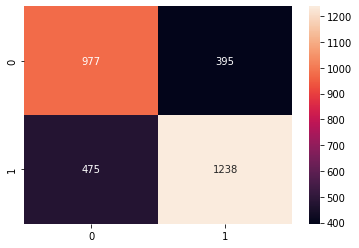

In [6]:
tree = node(max_depth = 7)
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, fmt='g')
print('accuray = {}'.format(accuracy_score(y_test,y_pred)))

In [54]:
class random_forrest():
  def __init__(self,n_tree = 3,max_depth = 3):
    self.n_tree = n_tree
    self.max_depth = max_depth
    #trees list to be filled later
    self.trees = [None]*n_tree

  def boostrap(self, input_x, input_y):
    boostrap_size = round(2*len(input_x)/3)
    randomIndices = np.random.randint(low = 0, high = len(input_x), size = boostrap_size)
    input_x = input_x.iloc[randomIndices, :] 
    input_y = input_y.iloc[randomIndices]
    column_size = round(np.sqrt(len(input_x.columns)))
    x_cols = input_x.columns[np.random.randint(low = 0, high = len(input_x.columns),size = column_size)]
    input_x = input_x.drop(labels = x_cols,axis = )
    return input_x, input_y
  
  def fit(self, train_set_x, train_set_y):
    for i in range(self.n_tree):
      print(i)
      temp_x ,temp_y = self.boostrap(train_set_x, train_set_y)
      self.trees[i] = node(max_depth=self.max_depth)
      self.trees[i].fit(temp_x,temp_y)


  def predict(self, test_x):
    predictions = np.zeros((self.n_tree, len(test_x)))
    for i in range(self.n_tree):
      predictions[i] = self.trees[i].predict(test_x)
    out = []
    for i in range(len(predictions[0])):
      sum = 0
      for j in range(len(predictions)):
        sum += predictions[j][i]
      out.append(int(1 < sum*2/len(predictions)))

    return out

In [69]:
forrest = random_forrest(max_depth=3)
forrest.fit(x_train, y_train)
predictions_forrest = forrest.predict(x_test)

accuray = 0.706645056726094


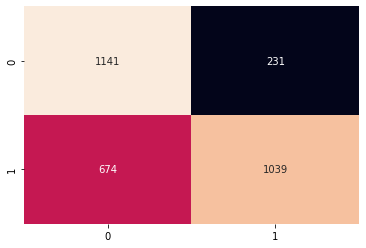

In [73]:
sns.heatmap(confusion_matrix(y_test, predictions_forrest), annot= True, fmt='g',cbar=False)
print('accuray = {}'.format(accuracy_score(y_test,predictions_forrest)))